# 3_Gaussian_Discriminant_Analysis

In [95]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt # Needs for Ploting
%matplotlib inline
torch.manual_seed(888)    # reproducible

## Prepare Data

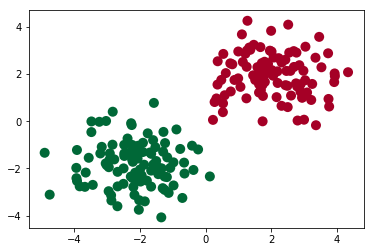

Variable containing:
 1.7509  1.0727  0.0000
 1.5829  2.2945  0.0000
 1.7470  2.3874  0.0000
 1.8278  2.0065  0.0000
 1.2780  4.2603  0.0000
 0.3709  2.5439  0.0000
 3.7689  0.6248  0.0000
 1.6728  3.1439  0.0000
 1.8087  1.6694  0.0000
 2.1909  2.1154  0.0000
 2.8952  1.2510  0.0000
 2.6953  2.3028  0.0000
 3.4644  3.5781  0.0000
 1.1094  3.6836  0.0000
 2.0126  2.9574  0.0000
 2.5880  2.1365  0.0000
 1.4710  3.2415  0.0000
 1.0651  1.4581  0.0000
 1.9995  3.8348  0.0000
 0.2276  0.0585  0.0000
 1.3644  3.0303  0.0000
 3.7490  0.9457  0.0000
 2.0758  2.7020  0.0000
 2.8063  0.0308  0.0000
 2.6891  2.9740  0.0000
 3.5332  2.2885  0.0000
 3.2225  0.9031  0.0000
 1.6869  1.9782  0.0000
 2.0209  2.1683  0.0000
 2.3216  2.4920  0.0000
 1.6878  1.3202  0.0000
 2.9586  1.0190  0.0000
 3.3667 -0.1684  0.0000
 2.4369  1.5300  0.0000
 0.9959  1.8187  0.0000
 0.5426  2.8555  0.0000
 3.0954  1.2205  0.0000
 2.7931  1.4760  0.0000
 2.4333  2.6103  0.0000
 1.7402 -0.0025  0.0000
 0.6184  2.0415  0.

In [300]:
# make fake data
n_data = torch.ones(100, 2)

x0 = torch.normal(2*n_data, 1)        # class0 x data (tensor), shape=(100, 2)   mu=(2,2), var =1
y0 = torch.zeros(100,1)               # class0 y data (tensor), shape=(100, 1)

x1 = torch.normal(-2*n_data, 1)       # class1 x data (tensor), shape=(100, 2)   mu=(-2,2), var=1
y1 = torch.ones(100,1)                # class1 y data (tensor), shape=(100, 1)

x = torch.cat((x0, x1)).type(torch.FloatTensor)    # shape (200, 2) FloatTensor = 32-bit floating
y = torch.cat((y0, y1)).type(torch.FloatTensor)    # shape (200, 1) FloatTensor = 32-bit integer

# torch can only train on Variable, so convert them to Variable
x,y = Variable(x),Variable(y)

plt.scatter(x.data.numpy()[:,0], x.data.numpy()[:,1], c=y.squeeze().numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()

torch.cat((x, y),dim=1)

## GDA Model and Parameters Estimation

### $p(y=1) = \phi = \frac{1}{m}\sum_{i=1}^{m}{1\{y^{(i)}=1}\}$  

In [239]:
phi1 = (y==1).sum().float()/200
phi0 = 1-phi1
phi1

Variable containing:
 0.5000
[torch.FloatTensor of size 1]

### $\mu_0 = \frac{
\sum_{i=1}^{m}{1\{y^{(i)}=0}\} x^{(i)} } {
\sum_{i=1}^{m}{1\{y^{(i)}=0}\} } $

In [219]:
mu0 = x[(y==0).squeeze(),:].mean(0,keepdim=True)
mu0

Variable containing:
 2.0390  2.0359
[torch.FloatTensor of size 1x2]

### $\mu_1 = \frac{
\sum_{i=1}^{m}{1\{y^{(i)}=1}\} x^{(i)} } {
\sum_{i=1}^{m}{1\{y^{(i)}=1}\} } $

In [225]:
mu1 = x[(y==1).squeeze(),:].mean(0,keepdim=True)
mu1

Variable containing:
-1.9310 -2.0366
[torch.FloatTensor of size 1x2]

### $\Sigma = diag(1,1)$

In [250]:
sigma0 = Variable(torch.ones(1,2))
sigma1 = Variable(torch.ones(1,2))
sigma0

Variable containing:
 1  1
[torch.FloatTensor of size 1x2]

## Prediction (Test)

In [281]:
a_sample = torch.ones(1, 2)
x_new = Variable(torch.normal(-2*a_sample, 1))        # sample x_new ~ Gaussian( mu=(2,2), var=diag(1,1))  (class0) 
x_new

Variable containing:
-2.8785 -3.0612
[torch.FloatTensor of size 1x2]

### Gaussian Distribution
### $ p(x;\mu, \sigma)=\frac{1}{\sqrt{2\pi|\Sigma|} }\exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right) $


In [290]:
K=1
def get_k_likelihoods(X, mu, var):
    if var.eq(0).any():
        raise Exception('variances must be nonzero')
    coeff = 1. / ((2*np.pi * var).prod(dim=1)).sqrt()        # (K )
    sigma_inv = 1./var                                       # (K, features)
    diff = X - mu.unsqueeze(1)                               # (K, examples, feature)    
    exponent = -0.5 * ( diff **2 @ sigma_inv.unsqueeze(2) )
    likelihoods = coeff.view(K,1,1) * torch.exp( exponent )
    return likelihoods.squeeze(2)

### likelihood $p(x|y=1) $

In [283]:
prob1 = get_k_likelihoods(x_new,mu1,sigma1)
prob1

Variable containing:
1.00000e-02 *
  6.0106
[torch.FloatTensor of size 1x1]

### likelihood $p(x|y=0) $

In [284]:
prob0 = get_k_likelihoods(x_new,mu0,sigma0)
prob0

Variable containing:
1.00000e-12 *
  2.0371
[torch.FloatTensor of size 1x1]

### Decision Rule
### y=1 if $\frac{p(x|y=1)p(y=1)}{p(x|y=0)p(y=0)} > 1$

In [285]:
(prob1 * phi1) / (prob0 * phi0)  > 1

Variable containing:
 1
[torch.ByteTensor of size 1x1]

### Bayese Rule
## $p(y=1|x)=\frac{p(x|y=1)p(y=1)}{p(x|y=1)p(y=1) + p(x|y=0)p(y=0)}$

In [286]:
p1 = (prob1 * phi1) / ((prob1 * phi1)+(prob0 * phi0))
p1

Variable containing:
 1
[torch.FloatTensor of size 1x1]

In [287]:
1-p1

Variable containing:
 0
[torch.FloatTensor of size 1x1]

## Draw Sample from GDA Model

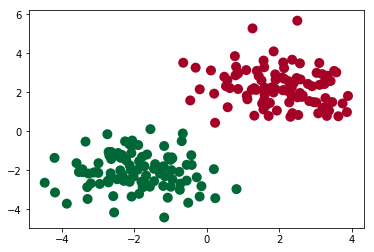

In [299]:
# make fake data
n_data = torch.ones(100, 2)

x0 = torch.normal(mu0.repeat(100,1).data, 1)        # class0 x data (tensor), shape=(100, 2)   mu=(2,2), var =1
y0 = torch.zeros(100,1)                             # class0 y data (tensor), shape=(100, 1)

x1 = torch.normal(mu1.repeat(100,1).data, 1)        # class1 x data (tensor), shape=(100, 2)   mu=(-2,2), var=1
y1 = torch.ones(100,1)                              # class1 y data (tensor), shape=(100, 1)

x_sample = torch.cat((x0, x1)).type(torch.FloatTensor)     # shape (200, 2) FloatTensor = 32-bit floating
y_sample = torch.cat((y0, y1)).type(torch.FloatTensor)     # shape (200, 1) FloatTensor = 32-bit integer

# torch can only train on Variable, so convert them to Variable
x_sample,y_sample = Variable(x_sample),Variable(y_sample)

plt.scatter(x_sample.data.numpy()[:,0], x.data.numpy()[:,1], c=y_sample.squeeze().numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()